<a href="https://colab.research.google.com/github/space-data-robert/python-machine-regressor/blob/master/%EC%A0%9C%EC%A3%BC%EB%8F%84_%EA%B5%90%ED%86%B5%EB%9F%89_%ED%9A%8C%EA%B7%80_%EC%98%88%EC%B8%A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive

/content/drive/MyDrive


### 제주도 도로 교통량 예측 (베이스라인 모델)

데이콘에서 흥미로운 데이터가 있어 공유를 드리려 합니다.

자세한 정보는 데이콘에서 확인할 수 있답니다.
- [제주도 도로 교통량 예측](https://dacon.io/competitions/official/235985/overview/description)

In [ ]:
import warnings
warnings.filterwarnings('ignore')

target = 'target'
drop_features = list()

먼저 타겟과 전처리 후에 사용하지 않을 리스트를 선언합니다.

그리고 데이터셋을 로드해볼게요.

데이터셋에는 날짜와 도로 정보가 담겨있는 것을 확인할 수 있네요.

In [ ]:
import pandas as pd
pd.set_option('display.max_columns', 8)

data = pd.read_csv('train.csv')
data.pop('id')

print(f'data shape = {data.shape}')
data.head(2)

data shape = (4701217, 22)


,base_date,day_of_week,base_hour,lane_count,...,end_latitude,end_longitude,end_turn_restricted,target
0,20220623,목,17,1,...,33.427749,126.662335,없음,52.0
1,20220728,목,21,2,...,33.504811,126.526240,없음,30.0


저는 보통 종속 변수를 먼저 확인하는 편입니다.

그런데 피처에 따라 타겟 분포가 다르다는 문제가 있어요.

이런 경우에는 데이터셋을 나뉘어 모델을 학습시키는 것도 하나의 방법이에요.

In [ ]:
target_group = 'maximum_speed_limit'

data[target_group] = data[target_group].apply(
    lambda x: str(int(x))
)

저는 오늘 그렇게 모델링을 해보려고 해요.

조금이라도 나은 성능을 기대하면서요.

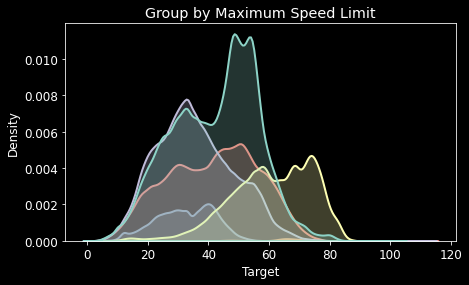

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('dark_background')
plt.rc('font', size=12)

plt.subplots(figsize=(7, 4))

g = sns.kdeplot(
    data=data, x=target, hue=target_group, 
    shade=True, linewidth=2, legend=False
)
g.set(title='Group by Maximum Speed Limit', xlabel='Target')

plt.show()

이럴 때는 분포의 왜도와 첨도를 확인하고 분포 변환을 할 수 있어요.

제한 속도에 따른 분포를 확인해보시죠.

In [ ]:
from scipy.stats import kurtosis, skew

kurtosis = data.groupby(
    target_group
).target.apply(kurtosis).to_frame('kurtosis').T

skewness = data.groupby(
    target_group
).target.apply(skew).to_frame('skewness').T

pd.concat([kurtosis, skewness], axis=0)

maximum_speed_limit,30,40,50,60,70,80
kurtosis,-0.580966,0.040824,-0.375705,-0.558128,-0.816051,0.221747
skewness,-0.214674,-1.010498,0.319214,-0.159346,-0.119153,-0.623005


박스콕스 분포 변환을 해도 별 효과는 없을 것 같아보입니다.

이제 데이터 탐색을 시작할건데요. 먼저 날짜 피처를 살펴보도록 하죠.

In [ ]:
data.base_date = pd.to_datetime(
    data.base_date, 
    format='%Y%m%d'
)
data.insert(0, 'year', 
    data.base_date.dt.year.astype(int)
)
data.insert(0, 'month', 
    data.base_date.dt.month.astype(int)
)

제한 속도에 따라 년도별 월별 그래프입니다.

8 월 데이터는 결측이고 7 월은 조금 전체적으로 속도가 감소하네요.

근데 40 Km 제한 도로의 평균 속도는 눈여겨 봐야할 것 같아요.

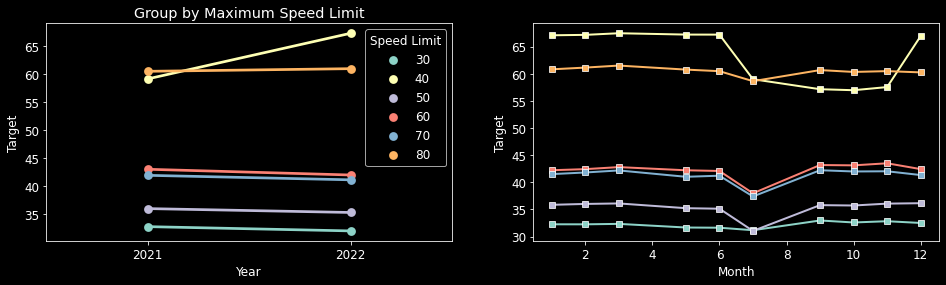

In [ ]:
figure, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
figure.set_size_inches(16, 4)

data.sort_values(
    by=target_group, inplace=True
)

sns.pointplot(
    data=data, x='year', y=target, hue=target_group, 
    ax=ax1, linewidth=2, ci=None, 
)
ax1.set(title='Group by Maximum Speed Limit', xlabel='Year', ylabel='Target')
ax1.legend(title='Speed Limit')

sns.lineplot(
    data=data, x='month', y=target, hue=target_group, 
    ax=ax2, linewidth=2, ci=None, marker='s'
)
ax2.set(xlabel='Month', ylabel='Target')
ax2.legend_.remove()

plt.show()

다음으로 요일을 살펴보도록 할게요.

아직 데이터를 살펴보지 않았지만 요일은 중요한 변수가 될 수 있겠죠?

주중과 주말 도로 사용은 목적이 다를테니까요.

In [ ]:
table = pd.pivot_table(
    data, 
    index=target_group, values=target, 
    columns='day_of_week', 
).astype(int)

table.filter(list('월화수목금토일'))

day_of_week,월,화,수,목,금,토,일
maximum_speed_limit,,,,,,,
30,32,32,32,32,32,32,32
40,63,62,62,62,62,62,62
50,35,35,35,35,35,35,35
60,42,42,42,42,42,42,42
70,41,41,41,41,40,41,42
80,60,60,60,60,60,60,60


그러나 요일에 따라 별 차이가 없어 보이네요.

다음으로 시간대 피처를 살펴볼게요.

시간대는 의미가 있을까요?

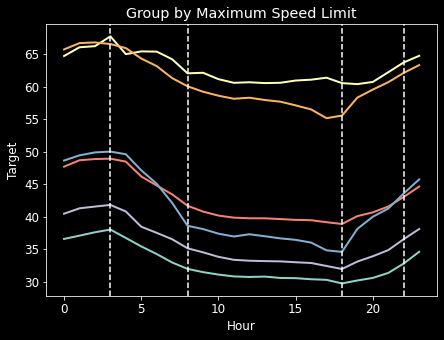

In [ ]:
plt.subplots(figsize=(7, 5))

g = sns.lineplot(
    data=data, x='base_hour', y=target, hue=target_group,
    linewidth=2, ci=None
)
hour_bin = [3, 8, 18, 22]
for hour in hour_bin:
    g.axvline(x=hour, linestyle='--')

g.set(title='Group by Maximum Speed Limit', xlabel='Hour', ylabel='Target')
g.legend_.remove()

plt.show()

시간대는 의미가 있는 것으로 보여지네요.

더불어 시간대는 비닝 카테고리를 함께 사용해볼게요.

In [ ]:
def hour(x):
    hour_bin = [3, 8, 18, 22]
    for enum, hour in enumerate(hour_bin):
        if x <= hour:
            return str(enum)
    return str(0)

data.insert(0, 'hour_bin', 
    data.base_hour.apply(hour)
)

그러나 요일에 따라 별 차이가 없어 보이네요.

날짜에서 년도와 요일 피처는 모델링에 제외하도록 할게요.

In [ ]:
drop_features.extend([
    'base_date', 'year', 'day_of_week'
])
pd.DataFrame(drop_features).T

,0,1,2
0,base_date,year,day_of_week


In [ ]:
data[['lane_count', 'road_rating', 'road_type', 'road_name', 'multi_linked', 'connect_code']].head()

,lane_count,road_rating,road_type,road_name,multi_linked,connect_code
2350608,1,107,0,-,0,0
4230936,1,106,0,지방도1112호선,0,0
2914821,1,107,3,-,0,0
420413,1,107,0,서사로,0,0
420409,1,107,0,시민광장로,0,0


In [ ]:
data[['vehicle_restricted', 'weight_restricted', 'height_restricted']].head()

,vehicle_restricted,weight_restricted,height_restricted
2350608,0.0,0.0,0.0
4230936,0.0,0.0,0.0
2914821,0.0,32400.0,0.0
420413,0.0,0.0,0.0
420409,0.0,0.0,0.0


In [ ]:
data[['start_node_name', 'start_latitude', 'start_longitude', 'start_turn_restricted', 'end_node_name', 'end_latitude', 'end_longitude', 'end_turn_restricted']].head()

,start_node_name,start_latitude,start_longitude,start_turn_restricted,end_node_name,end_latitude,end_longitude,end_turn_restricted
2350608,교보생명,33.449355,126.915027,없음,성산보건지소,33.450647,126.914649,없음
4230936,대흘교차로,33.468664,126.678235,없음,성미가든,33.437249,126.677154,없음
2914821,천제이교,33.244882,126.419089,없음,천제이교,33.245860,126.417641,없음
420413,서사라사거리,33.499848,126.519872,있음,삼오교,33.498151,126.519834,없음
420409,중문농협,33.251614,126.508321,없음,중문농협,33.252510,126.508644,없음


In [ ]:
# drop_features = list()
# skip_features = ['start_node_name', 'end_node_name']

# drop_features.append('id')


In [ ]:
from sklearn.preprocessing import FunctionTransformer

def weekday(x):
    return '주중' if x in list('월화수목금') else '주말'

FunctionTransformer(weekday)

ImportError: ignored

In [ ]:
from sklearn.pipeline import make_pipeline, Pipeline
ColumnTransformer
a = data.head(2)

pipeline = Pipeline([
    ('day_of_week', FunctionTransformer(weekday))
])

pipeline.transform(a)

ValueError: ignored

In [ ]:
drop_feature_name = list()
skip_feature_name = ['start_node_name', 'end_node_name']

drop_feature_name.append('id')

data.base_date = pd.to_datetime(
    data.base_date, 
    format='%Y%m%d'
)
drop_feature_name.append('base_date')

data.insert(0, 'year', 
    data.base_date.dt.year.astype(int)
)
data.insert(0, 'month', 
    data.base_date.dt.month.astype(int)
)
data.insert(0, 'weekday', 
    data.day_of_week.apply(
        lambda x: '주중' if x in list('월화수목금') else '주말')
)


airport_point = [33.510752, 126.492199]
data.insert(0, 'airport_distance', 
    (data.end_latitude - airport_point[0]) ** 2 + (data.end_longitude - airport_point[1]) ** 2
)
drop_feature_name.append('day_of_week')

data = data.drop(
    drop_feature_name + skip_feature_name,
    axis=1
)

print(f'data shape = {data.shape}')
data.head(2)

data shape = (4701217, 22)


,airport_distance,weekday,month,...,end_longitude,end_turn_restricted,target
0,0.035836,주중,6,...,126.662335,없음,52.0
1,0.001194,주중,7,...,126.526240,없음,30.0


In [ ]:
from sklearn.preprocessing import OrdinalEncoder

cate_feature_name = data.dtypes[data.dtypes == 'object'].index

print(cate_feature_name)

encoder = OrdinalEncoder()
data[cate_feature_name]=encoder.fit_transform(
    data[cate_feature_name]
)

Index(['weekday', 'road_name', 'start_turn_restricted', 'end_turn_restricted'], dtype='object')


In [ ]:
y_data = data.pop(target_name)

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb

random_state = 27

scaler = StandardScaler()
model = lgb.LGBMRegressor(
    random_state=random_state
)

pipeline = make_pipeline(scaler, model)

from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_absolute_error, mean_squared_log_error

val_score = cross_val_score(
    pipeline,
    data,
    y_data,
    cv=5,
    scoring=make_scorer(
        mean_absolute_error, 
        greater_is_better=False
    )
)
print(f'valid score = {-val_score.mean():.3f}')

valid score = 4.714


In [ ]:
x_data = data[data.maximum_speed_limit == range]
x_data

Int64Index([      0,       1,       5,       6,       7,       8,      10,
                 13,      14,      22,
            ...
            4701185, 4701187, 4701194, 4701199, 4701203, 4701204, 4701206,
            4701209, 4701214, 4701216],
           dtype='int64', length=1665573)

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb

random_state = 27

scaler = StandardScaler()
model = lgb.LGBMRegressor(
    random_state=random_state
)

pipeline = make_pipeline(scaler, model)

from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_absolute_error, mean_squared_log_error

ranges = data.maximum_speed_limit.unique()

for range in ranges:
    print('range =', range)
    x_data = data[data.maximum_speed_limit == range]
    data_ind = x_data.index

    val_score = cross_val_score(
        pipeline,
        x_data,
        y_data[data_ind],
        cv=5,
        scoring=make_scorer(
            mean_absolute_error, 
            greater_is_better=False
        )
    )
    print(f'valid score = {-val_score.mean():.3f}')

range = 60.0
valid score = 3.770
range = 80.0
valid score = 3.285
range = 50.0
valid score = 3.681
range = 70.0
valid score = 4.011
range = 30.0
valid score = 2.829
range = 40.0
valid score = 2.238


In [ ]:
data.columns

Index(['airport_distance', 'weekday', 'month', 'year', 'base_hour',
       'lane_count', 'road_rating', 'road_name', 'multi_linked',
       'connect_code', 'maximum_speed_limit', 'vehicle_restricted',
       'weight_restricted', 'height_restricted', 'road_type', 'start_latitude',
       'start_longitude', 'start_turn_restricted', 'end_latitude',
       'end_longitude', 'end_turn_restricted'],
      dtype='object')

In [ ]:
# data.maximum_speed_limit

Index(['airport_distance', 'weekday', 'month', 'year', 'base_hour',
       'lane_count', 'road_rating', 'road_name', 'multi_linked',
       'connect_code', 'maximum_speed_limit', 'vehicle_restricted',
       'weight_restricted', 'height_restricted', 'road_type', 'start_latitude',
       'start_longitude', 'start_turn_restricted', 'end_latitude',
       'end_longitude', 'end_turn_restricted', 'target'],
      dtype='object')

In [ ]:
all_feature_name = data.columns



feature_name = list()
for feat in all_feature_name:
    if feat == target_name:
        continue
    if feat in skip_feature_name:
        continue
    feature_name.append(feat)

print(f'feature count = {len(feature_name)}')

In [ ]:


str_col = ['day_of_week','start_turn_restricted','end_turn_restricted', 'year', 'month']

le = OrdinalEncoder()
df[str_col]=le.fit_transform(df[str_col])

drop_col = ['id','base_date', 'road_name', 'start_node_name', 'end_node_name','vehicle_restricted']

df.drop(drop_col, axis=1,  inplace=True)

In [ ]:
# data.groupby(['base_year', 'base_month']).target.describe()
# data.groupby(['base_day']).target.describe()

In [ ]:
all_feature_name = data.columns

skip_feature_name = ['start_node_name', 'end_node_name']

feature_name = list()
for feat in all_feature_name:
    if feat == target_name:
        continue
    if feat in skip_feature_name:
        continue
    feature_name.append(feat)

print(f'feature count = {len(feature_name)}')

In [ ]:
import warnings
warnings.filterwarnings('ignore')

이제 데이터를 불러보겠습니다.

470 만 건의 데이터이고 22 개 컬럼으로 이루어져 있네요.

In [ ]:
import pandas as pd
pd.set_option('display.max_columns', 7)

data = pd.read_csv('train.csv')
data.pop('id')

print(f'data shape = {data.shape}')
data.head(2)

data shape = (4701217, 22)


,base_date,day_of_week,base_hour,...,end_longitude,end_turn_restricted,target
0,20220623,목,17,...,126.662335,없음,52.0
1,20220728,목,21,...,126.526240,없음,30.0


저는 항상 타겟 분포를 가장 먼저 살펴보는 편이에요.



In [ ]:
data.describe(include='object')

,day_of_week,road_name,start_node_name,start_turn_restricted,end_node_name,end_turn_restricted
count,4992458,4992458,4992458,4992458,4992458,4992458
unique,7,61,487,2,487,2
top,수,일반국도12호선,고성교차로,없음,고성교차로,없음
freq,722557,1096232,42176,4486669,42276,4486552


In [ ]:
data.base_date = pd.to_datetime(
    data.base_date, 
    format='%Y%m%d'
)

data.insert(0, 'base_year', 
    data.base_date.dt.year.astype(int)
)
data.insert(1, 'base_month', 
    data.base_date.dt.month.astype(int)
)

data = data.drop('base_date', axis=1)

print(f'data shape = {data.shape}')
data.head(2)

data shape = (4992458, 23)


,base_year,base_month,day_of_week,...,end_longitude,end_turn_restricted,target
0,2022,6,목,...,126.662335,없음,52.0
1,2022,7,목,...,126.526240,없음,30.0


In [ ]:
from scipy.stats import kurtosis, skew

target = 'target'

kurtosis_ = kurtosis(
    data[target], 
    fisher=False
)
print(f'kurtosis = {kurtosis_: .3f}')

skewness = skew(
    data[target]
)
print(f'skewness = {skewness: .3f}')

data.isnull().sum().to_frame('null_count').T

kurtosis =  nan
skewness =  nan


,base_year,base_month,day_of_week,...,end_longitude,end_turn_restricted,target
null_count,0,0,0,...,0,0,291241


In [ ]:
all_feature = data.columns

skip_feature = ['start_node_name', 'end_node_name']

feature = list()
for feat in all_feature:
    if feat == target:
        continue
    if feat in skip_feature:
        continue
    feature.append(feat)

print(f'feature count = {len(feature)}')

feature count = 20


In [ ]:
x_data = pd.get_dummies(
    data[feature],
    dummy_na=False
)
y_data = data[target]

print(f'data shape = {x_data.shape}')
x_data.head(2)

data shape = (4701217, 88)


,base_year,base_month,base_hour,...,start_turn_restricted_있음,end_turn_restricted_없음,end_turn_restricted_있음
0,2022,6,17,...,0,1,0
1,2022,7,21,...,1,1,0


In [ ]:
from sklearn.feature_selection import SelectKBest, f_regression

feature_count = 50

selector = SelectKBest(f_regression, k=feature_count)

selector.fit_transform(x_data, y_data)

selected_mask = selector.get_support()
all_feature = x_data.columns

selected_feature = all_feature[selected_mask]

pd.DataFrame(selected_feature).T

,0,1,2,...,47,48,49
0,base_hour,lane_count,road_rating,...,start_turn_restricted_있음,end_turn_restricted_없음,end_turn_restricted_있음


In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb

random_state = 27

scaler = StandardScaler()
model = lgb.LGBMRegressor(
    random_state=random_state
)

pipeline = make_pipeline(scaler, model)

In [ ]:


from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_absolute_error, mean_squared_log_error

val_score = cross_val_score(
    pipeline,
    x_data[selected_feature],
    y_data,
    cv=3,
    scoring=make_scorer(
        mean_absolute_error, 
        greater_is_better=False
    )
)
print(f'valid score = {-val_score.mean():.3f}')

valid score = 6.377


In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor

seed = 27

baseline = RandomForestRegressor(random_state=seed)

pipeline = make_pipeline(baseline)

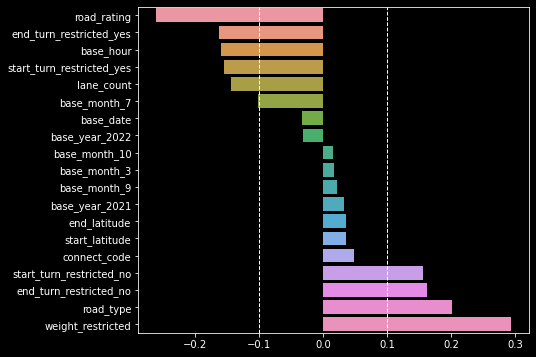

In [ ]:
plt.subplots(figsize=(7, 6))

x_data[target_name] = y_data

correlated_featrue = (
    x_data.corr()[target_name]
).sort_values()[:-2]

sns.barplot(
    x=correlated_featrue.values,
    y=correlated_featrue.index,
    orient='h',
)
point = [-0.1, 0.1]
for p in point:
    plt.axvline(x=p, linewidth=1, linestyle='--')
plt.show()

In [ ]:

다만 중요 변수가 무엇이 있는지 먼저 파악한다면

피처 엔지니어링 속도를 높일 수 있을거에요.

저는 피처 선택 모델로 중요한 피처가 무엇이 있는지 파악해 보려해요.

### **날짜 관련 변수**

처음으로 날짜 요일과 시간대가 보이는데요.

월별 도로 상황은 크게 변함이 없어보이네요.

다만 2022년 07월에는 평균 대비 낮은 값을 보이고 있습니다.

따라서 **07월은 어떤 부분이 다른지** 살펴볼 필요가 있어보입니다.

In [ ]:
data.base_date = pd.to_datetime(data.base_date, format='%Y%m%d')

data['base_year'] = data.base_date.dt.year
data['base_month'] = data.base_date.dt.month

grouped_data = data.groupby(
    ['base_year', 'base_month']
).target.mean()

grouped_data.to_frame().T

base_year       2021                                       2022             \
base_month        9          10         11         12        1          2    
target      43.69434  43.495717  43.728215  43.030021  43.03313  43.256182   

base_year                                               
base_month         3          5          6          7   
target      43.548673  42.639328  42.614157  36.282302

요일은 중요한 변수인 것 같아 보였으나 

In [ ]:
grouped_data = data.groupby('day_of_week').target.mean()

grouped_data.to_frame().T.filter(
    ['월', '화', '수', '목', '금', '토', '일']
)

day_of_week,월,화,수,목,금,토,일
target,42.761365,42.699198,42.770372,42.768345,42.450328,42.894117,43.1793


시간대에 따라서 도로 속도가 차이나는 것을 볼 수 있습니다.

**의미있는 결과**로 볼 수 있을 것 같네요.

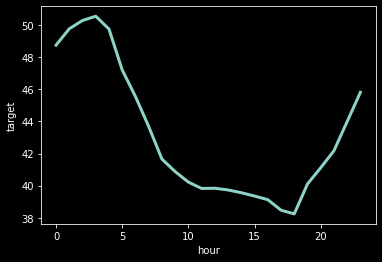

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('dark_background')

grouped_data = data.groupby('base_hour').target.mean()

plt.subplots(figsize=(6, 4))

g = grouped_data.plot(
    linewidth=3
)
g.set(xlabel='hour', ylabel='target')

plt.show()

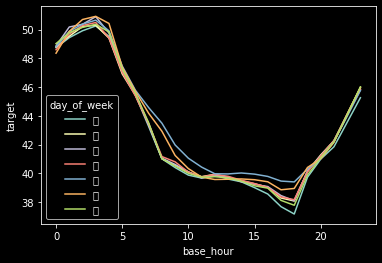

In [ ]:
import seaborn as sns

grouped_data = data.groupby(
    ['base_hour', 'day_of_week']
).target.mean().reset_index()

plt.subplots(figsize=(6, 4))

g = sns.lineplot(
    data=grouped_data,
    x='base_hour', y='target', hue='day_of_week'
)
# g.set(xlabel='hour', ylabel='target')

plt.show()

In [ ]:
# 차로 수 ```lane_count``` 도로 등급 ```road_rating``` 에 따른 도로명 ```road_name``` 이 보입니다.

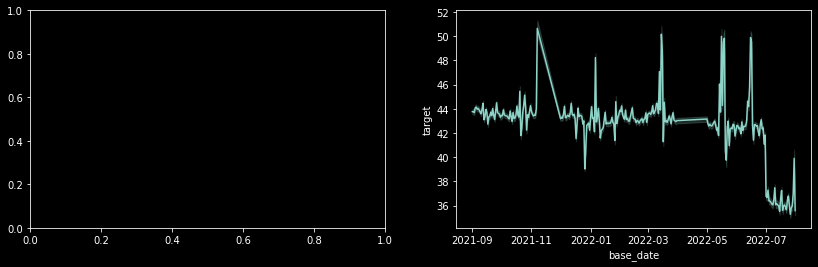

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('dark_background')

figure, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
figure.set_size_inches(14, 4)

sns.regplot(data=data, x='base_date', y='target', 
            
            ax=ax1)
sns.lineplot(data=data, x='base_month', y='target', ax=ax2)
plt.show()

In [ ]:
import seaborn as sns

In [ ]:
data.loc[:1, ('base_date', 'day_of_week', 'base_hour')]

,base_date,day_of_week,base_hour
0,20220623,목,17
1,20220728,목,21


타임 스탬프는 분리해서 보는게 제맛이죠.

In [ ]:
data.base_date = to_datetime(data, format='%Y%m%d')

data.insert(0, 'base_month', data.base_date.month)
data.insert(0, 'base_year', data.base_date.year)



In [ ]:
data['day_of_week'] = data['day_of_week'].map({
    '월': 'mon', '화': 'tue', 
    '수': 'wed', '목': 'thu', 
    '금': 'fri', '토': 'sat', '일': 'sun',
})

data['week_day'] = data['day_of_week'].apply(
    lambda x: 'weekend' if x[0] == 's' else 'weekday'
)

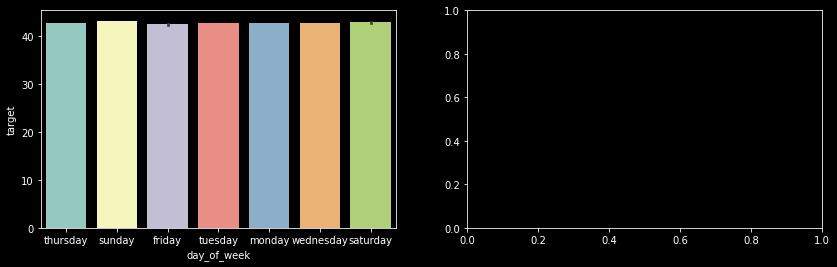

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('dark_background')

figure, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
figure.set_size_inches(14, 4)

sns.barplot(data=data, x='day_of_week', y='target', ax=ax1)

sns.barplot(data=data, x='week_day', y='target', ax=ax2)

plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('dark_background')

figure, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
figure.set_size_inches(14, 4)

sns.barplot(data=data, x='day_of_week', )

In [ ]:
data.base_date = to_datetime(data, format='%Y%m%d')

data.insert(0, 'base_month', data.base_date.month)
data.insert(0, 'base_year', data.base_date.year)

,base_date,day_of_week,base_hour
0,20220623,목,17
1,20220728,목,21


In [ ]:
data.base_date = to_datetime(data, format='%Y%m%d')

data.insert(0, 'base_month', data.base_date.month)
data.insert(0, 'base_year', data.base_date.year)

In [ ]:

# 차로 수 ```lane_count``` 도로 등급 ```road_rating``` 에 따른 도로명 ```road_name``` 이 보입니다.

In [ ]:
column_name = [
    'base_date', 'day_of_week', 'base_hour',
    'lane_count', 'road_rating', 'road_name'
]
data.loc[:1, column_name]

,base_date,day_of_week,base_hour,lane_count,road_rating,road_name
0,20220623,목,17,1,106,지방도1112호선
1,20220728,목,21,2,103,일반국도11호선


그리고 중용 구간 ```multi_linked``` 이 있는데요.

도로 구간에는 전용 구간과 중용 구간이 있다네요.

* 전용 구간이란 하나의 노선이 도로를 전적으로 사용하는 구간
* 중용 구간은 2개 이상의 노선이 도로의 일정 구간을 공동으로 사용하는 구간

계속해서 연결로 코드 ```connect_code``` 속도제한 ```maximum_speed_limit``` 이 있구요.

통과 제한 차량 ```vehicle_restricted``` 통과 제한 하중 ```weight_restricted``` 그리고

통과 제한 높이 ```height_restricted``` 가 있네요. 

* 제한 정보에 따라 시간대별 교통량이 다르지 않을까 싶네요.

In [ ]:
column_name = [
    'multi_linked', 'connect_code', 'maximum_speed_limit', 
    'vehicle_restricted', 'weight_restricted', 'height_restricted'
]
data.loc[:1, column_name]

,multi_linked,connect_code,maximum_speed_limit,vehicle_restricted,weight_restricted,height_restricted
0,0,0,60.0,0.0,32400.0,0.0
1,0,0,60.0,0.0,0.0,0.0


이제 도로 유형 ```road_type``` 과 시작 지점명 ```start_node_name``` 도착 지점명 ```end_node_name```

시작 지점의 경도 ```start_latitude``` 와 위도 ```start_longitude``` 그리고

도착 지점의 경도 ```end_latitude``` 와 위도 ```end_longitude``` 가 있어요.

더불어 시작 지점의 회전 제한 유무 ```start_turn_restricted```

도착 지점의 회전 제한 유무 ```end_turn_restricted``` 가 존재하네요.

In [ ]:
column_name = [
    'road_type', 'start_node_name', 'end_node_name', 'start_latitude', 'start_longitude',
    'end_latitude', 'end_longitude', 'start_turn_restricted', 'end_turn_restricted'
]
data.loc[:1, column_name]

,road_type,start_node_name,end_node_name,start_latitude,start_longitude,end_latitude,end_longitude,start_turn_restricted,end_turn_restricted
0,3,제3교래교,제3교래교,33.427747,126.662612,33.427749,126.662335,없음,없음
1,0,광양사거리,KAL사거리,33.500730,126.529107,33.504811,126.526240,있음,없음


마지막으로 평균 속도 ```target``` 가 우리의 타겟 또는 종속 변수가 될거에요.

우리 타겟이 어떤 분포인지 확인해보면 뭔가 이상하네요.

In [ ]:
target_name = 'target'

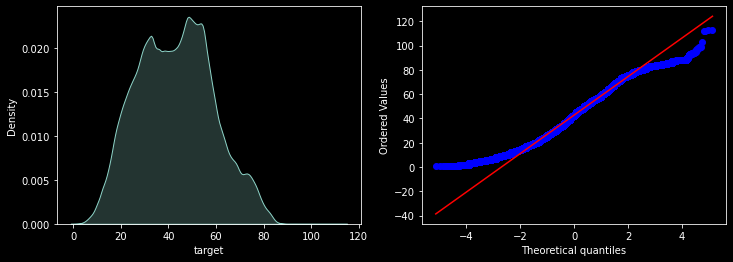

In [ ]:
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('dark_background')

figure, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
figure.set_size_inches(12, 4)

sns.kdeplot(
    data=data[target_name],
    ax=ax1, shade=True
)
stats.probplot(
    data[target_name], 
    plot=ax2
)
ax2.set(title=None)
plt.show()

박스콕스 변환을 실시해보도록 할게요.

lambda param =  0.75222


박스 콕스 변환에는 람다가 필요한데요.

람다에 대한 자료는 [블로그](https://seeyapangpang.tistory.com/35)에 잘 정리가 되어있네요.

data shape = (4701217, 22)


,base_date,day_of_week,base_hour,lane_count,road_rating,...,end_node_name,end_latitude,end_longitude,end_turn_restricted,target
0,20220623,목,17,1,106,...,제3교래교,33.427749,126.662335,없음,25.015132
1,20220728,목,21,2,103,...,KAL사거리,33.504811,126.526240,없음,16.269588


미세하게 분포가 변환된 것을 확인할 수 있습니다.

정확도를 조금이라도 올리기 위해 사용하겠습니다.

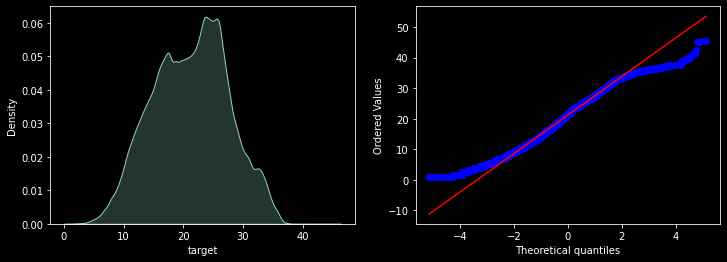

In [ ]:
figure, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
figure.set_size_inches(12, 4)

sns.kdeplot(
    data=data[target_name],
    ax=ax1, shade=True
)
stats.probplot(
    data[target_name], 
    plot=ax2
)
ax2.set(title=None)

kurtosis_ = kurtosis(
    data[target_name], 
    fisher=False
)
plt.show()

이제 결측치를 확인해보면 아무것도 없는 것으로 보여지구요.

바로 베이스라인 모델링을 진행하면 될 것 같군요.

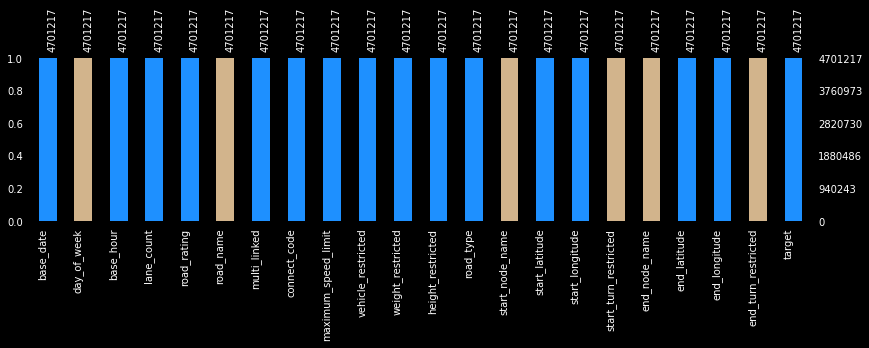

In [ ]:
import missingno as msno

msno.bar(data,
    figsize=(14, 3), fontsize=10, label_rotation=90,
    color=['tan' if data.dtypes[c] == 'object' else 'dodgerblue' for c in data.columns]
)
plt.show()

카테고리 변수는 기술 통계를 확인해볼게요.

시작 지점명 ```start_node_name``` 과 도착 지점명	```end_node_name``` 을 더미화 할 경우 

쓸데없이 높은 차원의 데이터로 변환이 될겁니다.

In [ ]:
data.describe(include=['object'])

,day_of_week,road_name,start_node_name,start_turn_restricted,end_node_name,end_turn_restricted
count,4701217,4701217,4701217,4701217,4701217,4701217
unique,7,61,487,2,487,2
top,금,일반국도12호선,고성교차로,없음,고성교차로,없음
freq,684024,1046092,42169,4239701,42265,4239599


따라서 베이스라인 모델링에서는 이를 제거하고 진행하도록 합니다.

In [ ]:
x_data = pd.get_dummies(
    data.drop(
        ['start_node_name','end_node_name'],
        axis=1),
    dummy_na=True
)
y_data = x_data.pop(target_name)

print(f'x data shape = {x_data.shape}')
x_data.head(2)

x data shape = (4701217, 91)


,base_date,base_hour,lane_count,road_rating,multi_linked,...,start_turn_restricted_있음,start_turn_restricted_nan,end_turn_restricted_없음,end_turn_restricted_있음,end_turn_restricted_nan
0,20220623,17,1,106,0,...,0,0,1,0,0
1,20220728,21,2,103,0,...,1,0,1,0,0


다음으로 중요한 피처가 어떠한 것들이 있는지 쓱 파악할거에요.

그 방법으로 피처 선택 모델을 활용합니다.
- 선택할 피처 개수는 50개

In [ ]:
from sklearn.feature_selection import SelectKBest, f_regression

feature_count = 50

selector = SelectKBest(f_regression, k=feature_count)

이제 피팅을 시켜서 중요 피처를 확인해봅니다.

50개 피처가 뽑혔고 이산 데이터의 경우

언더바로 중요값까지 뽑힌걸 확인할 수 있을거에요.

In [ ]:
from sklearn.feature_selection import SelectKBest, f_regression

feature_count = 50

selector = SelectKBest(f_regression, k=feature_count)

%time selector.fit_transform(x_data, y_data)

selected_mask = selector.get_support()
all_feature = x_data.columns

selected_feature_name = all_feature[selected_mask]

feature_name = list(set(
    ['_'.join(f.split('_')[:2]) for f in selected_feature_name])
)
pd.DataFrame(feature_name,columns=['importance']).T

from sklearn.model_selection import train_test_split

seed = 27

x_train, x_test, y_train, y_test = train_test_split(
    x_data[selected_feature_name], y_data, 
    test_size=0.3, random_state=seed
)

print(f'train shape = {x_train.shape}, {y_train.shape}')
x_train.head(2)

CPU times: user 3.76 s, sys: 161 ms, total: 3.92 s
Wall time: 3.58 s


이 작업을 통해 우리는 피처 엔지니어링에서

선택과 집중을 할 수 있을 것이라 믿어요.
- 중요 피처 바탕의 탐색적 분석

In [ ]:
feature_name = list(set(
    ['_'.join(f.split('_')[:2]) for f in selected_feature_name])
)
pd.DataFrame(feature_name,columns=['importance']).T

,0,1,2,3,4,5,6,7,8,9
importance,road_rating,lane_count,connect_code,weight_restricted,end_turn,road_type,road_name,base_hour,start_turn,maximum_speed


In [ ]:
from sklearn.model_selection import train_test_split

seed = 27

x_train, x_test, y_train, y_test = train_test_split(
    x_data[selected_feature_name], y_data, 
    test_size=0.3, random_state=seed
)

print(f'train shape = {x_train.shape}, {y_train.shape}')
x_train.head(2)

train shape = (3290851, 50), (3290851,)


,base_hour,lane_count,road_rating,connect_code,maximum_speed_limit,...,road_name_한천로,start_turn_restricted_없음,start_turn_restricted_있음,end_turn_restricted_없음,end_turn_restricted_있음
2294342,19,2,103,0,50.0,...,0,1,0,1,0
1072944,4,3,107,0,60.0,...,0,1,0,0,1


베이스라인 모델링 마지막 부분입니다.

피처 엔지니어링 전에 오토 사이킷런으로 예측 베이스라인을 잡을거에요.

- 10분간 적합한 모델 탐색
- 앙상블 크기는 5

모델링에는 하기 라이브러리를 사용해요.

```
!pip install auto-sklearn
```



In [ ]:
from autosklearn.regression import AutoSklearnRegressor
from autosklearn.metrics import mean_squared_error

minute = 10

automl = AutoSklearnRegressor(
    load_models=True,
    time_left_for_this_task=60*minute,
    resampling_strategy='cv',
    metric=mean_squared_error,
    ensemble_size=5,
    memory_limit=10**4,
    seed=seed,
)
automl.fit(x_train, y_train)

[WARNING] [2022-12-08 09:13:39,029:Client-EnsembleBuilder] No runs were available to build an ensemble from
[WARNING] [2022-12-08 09:14:41,158:Client-EnsembleBuilder] No runs were available to build an ensemble from
[WARNING] [2022-12-08 09:15:11,148:Client-EnsembleBuilder] No runs were available to build an ensemble from
[WARNING] [2022-12-08 09:15:25,012:Client-EnsembleBuilder] No runs were available to build an ensemble from
[WARNING] [2022-12-08 09:16:26,845:Client-EnsembleBuilder] No runs were available to build an ensemble from
[WARNING] [2022-12-08 09:17:01,609:Client-EnsembleBuilder] No runs were available to build an ensemble from
[WARNING] [2022-12-08 09:17:18,030:Client-EnsembleBuilder] No runs were available to build an ensemble from
[WARNING] [2022-12-08 09:17:28,922:Client-EnsembleBuilder] No runs were available to build an ensemble from
[WARNING] [2022-12-08 09:17:39,889:Client-EnsembleBuilder] No runs were available to build an ensemble from
[WARNING] [2022-12-08 09:17:

AutoSklearnRegressor(ensemble_class=<class 'autosklearn.ensembles.ensemble_selection.EnsembleSelection'>,
                     ensemble_kwargs={'ensemble_size': 5}, ensemble_size=5,
                     memory_limit=10000, metric=mean_squared_error,
                     per_run_time_limit=60, resampling_strategy='cv', seed=27,
                     time_left_for_this_task=600)

예측 결과와 앙상블에 활용된 모델을 표시합니다.

베이스라인 결과를 바탕으로 개선을 실시할 수 있습니다.

In [ ]:
y_pred = automl.predict(x_test)

test_score = mean_squared_error(
    y_test, y_pred
)

print(f'test score = {-test_score:.5f}')

automl.leaderboard()

test score = 40.19270


,rank,ensemble_weight,type,cost,duration
model_id,,,,,
1,1,1.0,<NA>,<NA>,<NA>


In [ ]:
test_score_inv = inv_boxcox1p(-test_score, lam)

print(f'test score inverse = {test_score_inv:.5f}')

test score inverse = 96.03982
